In [39]:
import csv
import glob
import re
import os

In [40]:
from ete3 import Tree

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [42]:
tree = Tree("data/tree/time_tree.nw")

In [43]:
hsap_leaf = tree&"homo_sapiens"
ancestors = hsap_leaf.get_ancestors()

In [44]:
potential_ages = [0]

In [45]:
for node in ancestors:
    if node.is_root():
        continue
        
    _, age = node.get_farthest_leaf()
    potential_ages.append(age)

In [46]:
hsap_orth = dict()

In [47]:
for path in glob.iglob("data/homology/genes/*.csv"):
    base_name = os.path.basename(path)
    name = re.search(r'(?<=_)\w+', base_name).group(0)
    
    hsap_orth[name] = set()
    
    with open(path, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        
        for row in reader:
            # If `gene` (the human gene) is in the file, it
            # has at least some evidence of orthology in the comparison
            # species.
            gene, *_ = row
            hsap_orth[name].add(gene)

In [48]:
N = {'5': 0, '3': 0}
t = {'5': 0, '3': 0}

In [49]:
long_data = list()

In [50]:
with open("../data/homology/ss/out/origin.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)
    
    for row in reader:
        gene, meta_exon, p, pos, _, gain_ages, loss_ages, pos_group, neg_group, tree_size, _ = row
        
        if ";" in gain_ages or int(tree_size) < 3:
            # `";" in gain_ages` indicates more than one gain event, which
            # we've opted to exclude.
            continue
            
        if gain_ages == "homo_sapiens":
            age = 0
        else:
            age = float(gain_ages)
        
        neg_w_gene_homolog = set()
        
        for name in neg_group.split(";"):
            # BioMart abbreviates the species' names.
            *pre, suf = name.split("_")
            abbv = "".join([n[0] for n in pre]) + suf

            if gene in hsap_orth[abbv]:
                neg_w_gene_homolog.add(name)
            
        long_data.append({
            'p': p,
            'age': age,
            'cat': "new" if len(neg_w_gene_homolog) == 0 else "old"
        })
        
        N[p] += int(len(neg_w_gene_homolog) == 0)
        t[p] += 1

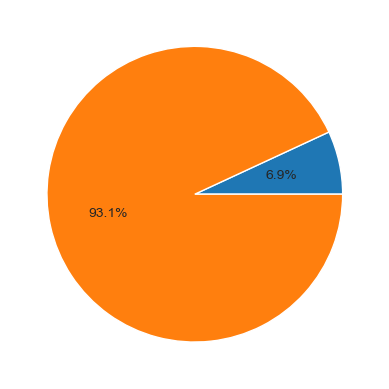

In [51]:
percent = (N['5'] + N['3']) / (t['5'] + t['3']) * 100

_ = plt.pie([percent, 100 - percent], autopct='%1.1f%%')
plt.savefig("figs/main2a.pdf")

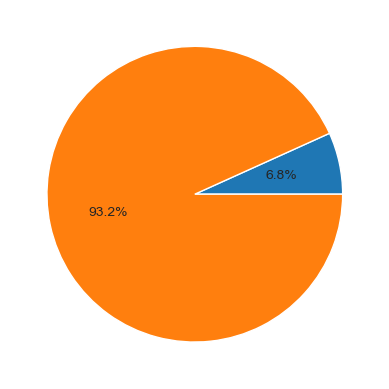

In [52]:
percent5 = N['5'] / t['5'] * 100

_ = plt.pie([percent5, 100 - percent5], autopct='%1.1f%%')
# plt.savefig("figs/main2a_5.pdf")

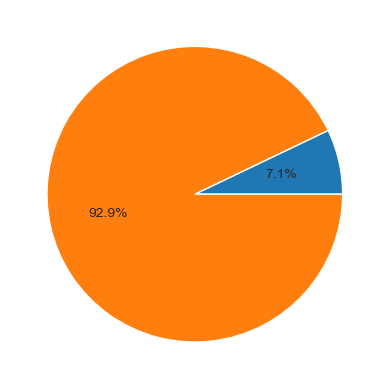

In [53]:
percent3 = N['3'] / t['3'] * 100

_ = plt.pie([percent3, 100 - percent3], autopct='%1.1f%%')
# plt.savefig("figs/main2a_3.pdf")

In [54]:
frame = pd.DataFrame(long_data)

In [55]:
frame5 = frame[frame['p'] == "5"]
frame3 = frame[frame['p'] == "3"]

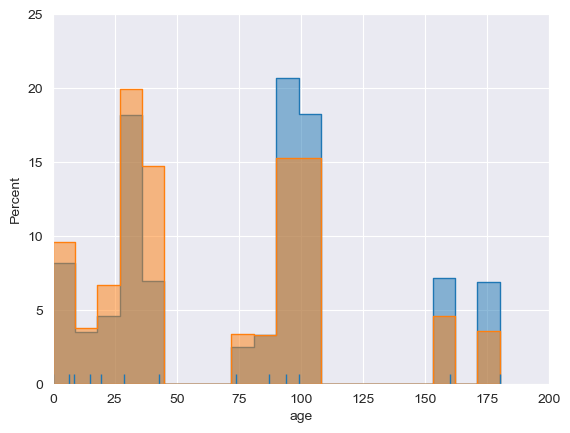

In [56]:
_ = sns.rugplot(x=potential_ages)

_ = sns.histplot(frame5[frame5['cat'] == "new"], x='age', stat='percent', bins=20, alpha=0.5, element='step')
_ = sns.histplot(frame5[frame5['cat'] == "old"], x='age', stat='percent', bins=20, alpha=0.5, element='step')

_ = plt.ylim(0, 25)
_ = plt.xlim(0, 200)

plt.savefig("figs/main2b_5.pdf")

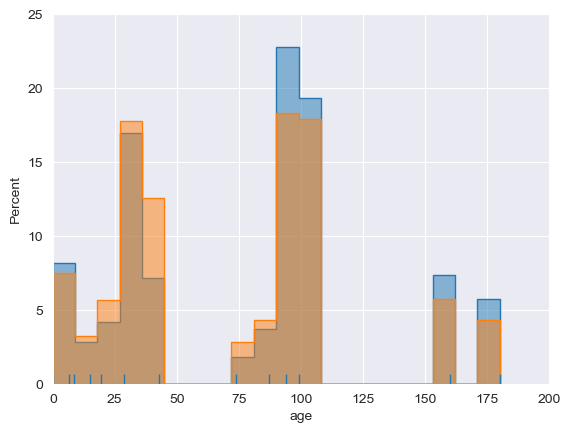

In [57]:
_ = sns.rugplot(x=potential_ages)

_ = sns.histplot(frame3[frame3['cat'] == "new"], x='age', stat='percent', bins=20, alpha=0.5, element='step')
_ = sns.histplot(frame3[frame3['cat'] == "old"], x='age', stat='percent', bins=20, alpha=0.5, element='step')

_ = plt.ylim(0, 25)
_ = plt.xlim(0, 200)

plt.savefig("figs/main2b_3.pdf")